# Experiment 12 attention map visualization

In [1]:
import re
import random

import torch
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp import plot_attn_maps, plot_module
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()

In [3]:
def load_model(ckpt_path: str) -> tuple[torch.nn.Module, dict]:
    # load model
    ckpt = torch.load(ckpt_path, map_location="mps")
    model = TransformerDecoder(
        **ckpt["hyper_parameters"]["model_hparams"],
        # vocab_size=tokenizer.vocab_size,
    )
    # state dict has a prefix "model." in the key names
    model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
    model.eval()
    return model, ckpt["hyper_parameters"]

In [4]:
# Exp 15

# CoT + finetuned
# model_name = "cot_finetuned"
# ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_cot/step670000-train_loss1.4532-val_loss1.4517.ckpt"

# just answer
# model_name = "answer_only"
# ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head/step302000-train_loss1.4523-val_loss1.4531.ckpt"

# CoT small
model_name = "cot_small"
ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_1layers_768embd_4head_cot/step56000-train_loss0.8101-val_loss0.7337.ckpt"

In [5]:
model, hparams = load_model(ckpt_path)

In [6]:
module_names = [mn for mn, _ in model.named_modules() if mn.endswith("self_attn")]

# replace index to get correct syntax
module_names = [re.sub(r"\.(\d+)\.", r"[\1].", mn) for mn in module_names]

module_names

['transformer_encoder.layers[0].self_attn']

In [7]:
# def eval_answer(model: torch.nn.Module, tokenizer, prompt: str, answer: str) -> bool:
#     """Return whether the model predicts the correct answer."""

#     prompt_tokens = torch.tensor(tokenizer.encode(prompt))
#     stop_token_id = tokenizer.encode("$")[0]

#     pred_ans = generate(
#         model, idx=prompt_tokens, max_new_tokens=20, stop_token=stop_token_id
#     )

#     pred_ans = tokenizer.decode(pred_ans[0])
#     pred_ans = pred_ans.strip("$")
#     return pred_ans == answer

In [8]:
# # find failure cases
# while True:
#     a = random.randint(10**5, 10**6)
#     b = random.randint(10**5, 10**6)
#     prompt = f"${a}+{b}="
#     true_ans = str(a + b)
#     if not eval_answer(model_before, tokenizer, prompt, true_ans) and not eval_answer(
#         model_after, tokenizer, prompt, true_ans
#     ):
#         break

# print(f"prompt: {prompt}")

In [9]:
subdir = PLOTS_DIR / "exp_15"
subdir.mkdir(exist_ok=True)

prompt: '$123456+678901=' 6+6
true_ans: 802357
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
pred_answer: 6+1=8c0,5+0=6c0,4+9=1c1,3+8=2c1,2+7=2c1,1+6=0c1|123456+778901=111188$
transformer_encoder.layers[0].self_attn torch.Size([1, 4, 83, 83])


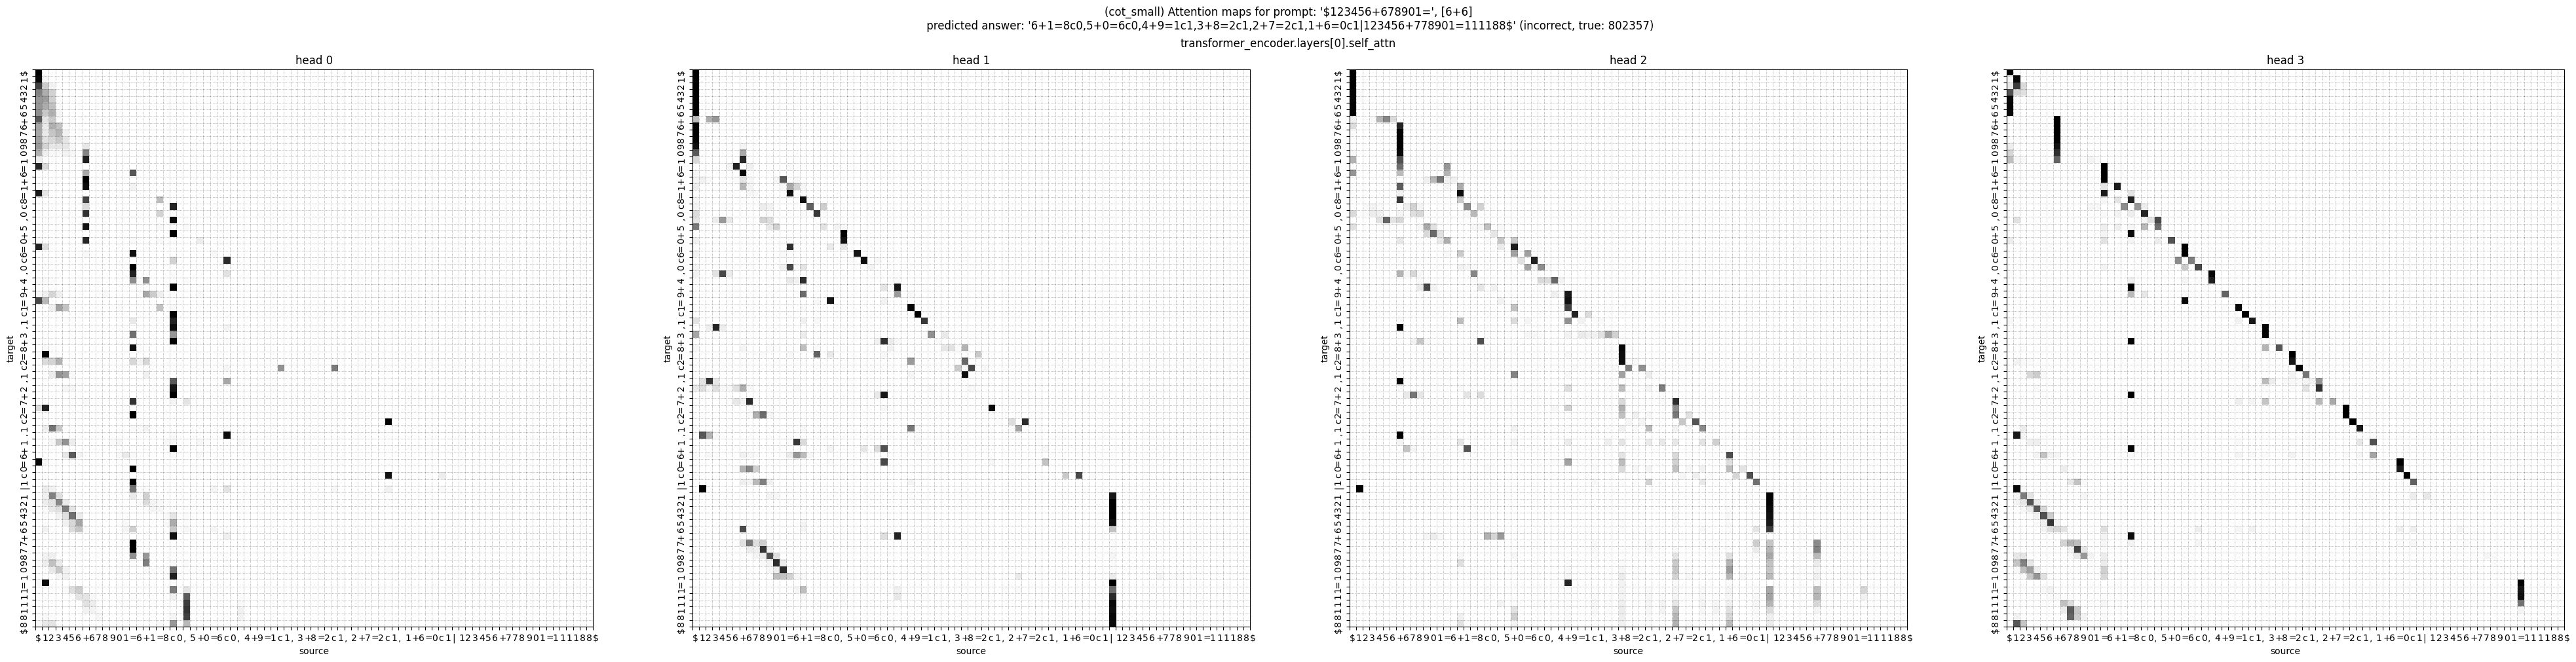

In [10]:
a, b = 123456, 678901
savepath = subdir / f"exp15_attention_maps_{a}+{b}_{model_name}.png"
fig_scale = 10
kwargs = dict(
    tokenizer=tokenizer,
    a=a,
    b=b,
    module_names=module_names,
    fig_scale=fig_scale,
    # save=True,
)
attn_maps = plot_attn_maps(
    model=model,
    savepath=str(savepath),
    figtitle_prefix=f"({model_name})",
    reverse_ops=False,
    reverse_ans=False,
    **kwargs,
)

In [1]:
import torch
from torch import nn


cache = []


# forward hook to save output
def hook(module, inputs, output):
    cache.append(output[0].detach())


enc_layer = nn.TransformerEncoderLayer(d_model=32, nhead=8, batch_first=True)
enc_layer.eval()

# register hook to get the output of the self-attention layer
handle = enc_layer.self_attn.register_forward_hook(hook)

# input tensor of shape (batch_size, seq_len, d_model)
x = torch.randn(4, 6, 32)

# forward pass
with torch.inference_mode():
    output = enc_layer(x)

# output of the self-attention layer
assert len(cache) == 1, f"Expected 1 output, got {len(cache)}"
print(cache[0].shape)

# remove hook
handle.remove()

AssertionError: Expected 1 output, got 0